In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import svm
from sklearn.preprocessing import OneHotEncoder
from sklearn.dummy import DummyRegressor
from sklearn.linear_model import LinearRegression
from sklearn.feature_selection import RFE
from sklearn.preprocessing import PolynomialFeatures, StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from statsmodels.formula.api import ols
import statsmodels.api as sm
import statsmodels.formula.api as smf
import scipy.stats as stats

In [2]:
df = pd.read_csv('../data/kc_house_data.csv')

In [3]:
df.describe()

,id,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,sqft_above,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
count,2.159700e+04,2.159700e+04,21597.000000,21597.000000,21597.000000,2.159700e+04,21597.000000,21597.000000,21597.000000,17755.000000,21597.000000,21597.000000,21597.000000,21597.000000,21597.000000
mean,4.580474e+09,5.402966e+05,3.373200,2.115826,2080.321850,1.509941e+04,1.494096,1788.596842,1970.999676,83.636778,98077.951845,47.560093,-122.213982,1986.620318,12758.283512
std,2.876736e+09,3.673681e+05,0.926299,0.768984,918.106125,4.141264e+04,0.539683,827.759761,29.375234,399.946414,53.513072,0.138552,0.140724,685.230472,27274.441950
min,1.000102e+06,7.800000e+04,1.000000,0.500000,370.000000,5.200000e+02,1.000000,370.000000,1900.000000,0.000000,98001.000000,47.155900,-122.519000,399.000000,651.000000
25%,2.123049e+09,3.220000e+05,3.000000,1.750000,1430.000000,5.040000e+03,1.000000,1190.000000,1951.000000,0.000000,98033.000000,47.471100,-122.328000,1490.000000,5100.000000
50%,3.904930e+09,4.500000e+05,3.000000,2.250000,1910.000000,7.618000e+03,1.500000,1560.000000,1975.000000,0.000000,98065.000000,47.571800,-122.231000,1840.000000,7620.000000
75%,7.308900e+09,6.450000e+05,4.000000,2.500000,2550.000000,1.068500e+04,2.000000,2210.000000,1997.000000,0.000000,98118.000000,47.678000,-122.125000,2360.000000,10083.000000
max,9.900000e+09,7.700000e+06,33.000000,8.000000,13540.000000,1.651359e+06,3.500000,9410.000000,2015.000000,2015.000000,98199.000000,47.777600,-121.315000,6210.000000,871200.000000


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21597 entries, 0 to 21596
Data columns (total 21 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   id             21597 non-null  int64  
 1   date           21597 non-null  object 
 2   price          21597 non-null  float64
 3   bedrooms       21597 non-null  int64  
 4   bathrooms      21597 non-null  float64
 5   sqft_living    21597 non-null  int64  
 6   sqft_lot       21597 non-null  int64  
 7   floors         21597 non-null  float64
 8   waterfront     19221 non-null  object 
 9   view           21534 non-null  object 
 10  condition      21597 non-null  object 
 11  grade          21597 non-null  object 
 12  sqft_above     21597 non-null  int64  
 13  sqft_basement  21597 non-null  object 
 14  yr_built       21597 non-null  int64  
 15  yr_renovated   17755 non-null  float64
 16  zipcode        21597 non-null  int64  
 17  lat            21597 non-null  float64
 18  long  

In [5]:
df.isna().sum()

id                  0
date                0
price               0
bedrooms            0
bathrooms           0
sqft_living         0
sqft_lot            0
floors              0
waterfront       2376
view               63
condition           0
grade               0
sqft_above          0
sqft_basement       0
yr_built            0
yr_renovated     3842
zipcode             0
lat                 0
long                0
sqft_living15       0
sqft_lot15          0
dtype: int64

In [6]:
df['waterfront'].value_counts()
#possibly use the mean to fill in missing values? also could just drop it but it is a substantial amount

NO     19075
YES      146
Name: waterfront, dtype: int64

In [7]:
df['yr_renovated'].value_counts()
#over 17000 missing results

0.0       17011
2014.0       73
2003.0       31
2013.0       31
2007.0       30
          ...  
1946.0        1
1959.0        1
1971.0        1
1951.0        1
1954.0        1
Name: yr_renovated, Length: 70, dtype: int64

In [8]:
#only 63 missing values of the view column, if we want to use it we can just drop.
df['view'].value_counts()

NONE         19422
AVERAGE        957
GOOD           508
FAIR           330
EXCELLENT      317
Name: view, dtype: int64

In [9]:
df['condition'].value_counts()

Average      14020
Good          5677
Very Good     1701
Fair           170
Poor            29
Name: condition, dtype: int64

In [10]:
df.waterfront.replace({'NO': 0, 'YES': 1}, inplace=True)
df.view.replace({'NONE': 0, 'FAIR': 1, 'AVERAGE': 2, 'GOOD': 3, 'EXCELLENT': 4}, inplace=True)
df.condition.replace({'Poor': 0, 'Fair': 1, 'Average': 2, 'Good': 3, 'Very Good': 4}, inplace=True)
df.grade.replace({'3 Poor': 0, '4 Low': 1, '5 Fair': 2, '6 Low Average': 3, '7 Average': 4, '8 Good': 5, 
                  '9 Better': 6, '10 Very Good': 7, '11 Excellent': 8, '12 Luxury': 9, '13 Mansion': 10}, inplace=True)
df.sqft_basement.replace('?', np.NaN, inplace=True)
df.sqft_basement = df.sqft_basement.astype(float)
#Replacing all the 'object' values with numeric values so we can still use them.

In [11]:
df.dropna(axis=0, how='any', subset=['view'], inplace=True)
#drop 63 rows because its a small amount for a relevant column

In [12]:
df['view'].isna().sum()

0

In [13]:
df.fillna(0, inplace=True)

In [14]:
df['condition'].value_counts()

2    13981
3     5657
4     1697
1      170
0       29
Name: condition, dtype: int64

In [15]:
df['view'].value_counts()

0.0    19422
2.0      957
3.0      508
1.0      330
4.0      317
Name: view, dtype: int64

In [16]:
df['waterfront'].value_counts()

0.0    21389
1.0      145
Name: waterfront, dtype: int64

In [17]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 21534 entries, 0 to 21596
Data columns (total 21 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   id             21534 non-null  int64  
 1   date           21534 non-null  object 
 2   price          21534 non-null  float64
 3   bedrooms       21534 non-null  int64  
 4   bathrooms      21534 non-null  float64
 5   sqft_living    21534 non-null  int64  
 6   sqft_lot       21534 non-null  int64  
 7   floors         21534 non-null  float64
 8   waterfront     21534 non-null  float64
 9   view           21534 non-null  float64
 10  condition      21534 non-null  int64  
 11  grade          21534 non-null  int64  
 12  sqft_above     21534 non-null  int64  
 13  sqft_basement  21534 non-null  float64
 14  yr_built       21534 non-null  int64  
 15  yr_renovated   21534 non-null  float64
 16  zipcode        21534 non-null  int64  
 17  lat            21534 non-null  float64
 18  long  

In [18]:
df.corr()

,id,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
id,1.000000,-0.017392,0.000991,0.004971,-0.012381,-0.132061,0.018573,-0.004259,0.011592,-0.023944,0.008331,-0.010967,-0.004312,0.021609,-0.010471,-0.008027,-0.002001,0.020637,-0.002707,-0.138607
price,-0.017392,1.000000,0.308063,0.525053,0.701587,0.090338,0.257052,0.259220,0.395734,0.035393,0.668307,0.605695,0.319082,0.054273,0.117982,-0.053620,0.307868,0.022417,0.585304,0.083189
bedrooms,0.000991,0.308063,1.000000,0.514368,0.577934,0.032735,0.177391,-0.003733,0.078523,0.026402,0.356095,0.479148,0.296548,0.155462,0.017797,-0.153990,-0.010415,0.132318,0.392874,0.030952
bathrooms,0.004971,0.525053,0.514368,1.000000,0.755277,0.088921,0.502285,0.061115,0.186451,-0.126682,0.665312,0.686173,0.277583,0.507565,0.046955,-0.204435,0.024487,0.225025,0.569139,0.088854
sqft_living,-0.012381,0.701587,0.577934,0.755277,1.000000,0.173768,0.353529,0.101982,0.282532,-0.059783,0.762398,0.876553,0.427422,0.318217,0.050871,-0.199839,0.052383,0.241856,0.756208,0.184801
sqft_lot,-0.132061,0.090338,0.032735,0.088921,0.173768,1.000000,-0.005025,0.021465,0.075298,-0.008375,0.115122,0.184325,0.015097,0.052646,0.005091,-0.129846,-0.085143,0.230137,0.145142,0.717095
floors,0.018573,0.257052,0.177391,0.502285,0.353529,-0.005025,1.000000,0.020357,0.028436,-0.264138,0.458694,0.523367,-0.242348,0.489410,0.003317,-0.058966,0.049419,0.125329,0.279176,-0.010850
waterfront,-0.004259,0.259220,-0.003733,0.061115,0.101982,0.021465,0.020357,1.000000,0.382000,0.016224,0.081195,0.069931,0.080917,-0.025000,0.074327,0.029490,-0.012282,-0.037845,0.082352,0.030605
view,0.011592,0.395734,0.078523,0.186451,0.282532,0.075298,0.028436,0.382000,1.000000,0.045735,0.249727,0.166299,0.271689,-0.054564,0.090324,0.085277,0.006141,-0.077894,0.279561,0.073332
condition,-0.023944,0.035393,0.026402,-0.126682,-0.059783,-0.008375,-0.264138,0.016224,0.045735,1.000000,-0.147326,-0.158830,0.167889,-0.361398,-0.055730,0.002125,-0.015594,-0.105475,-0.093172,-0.002702


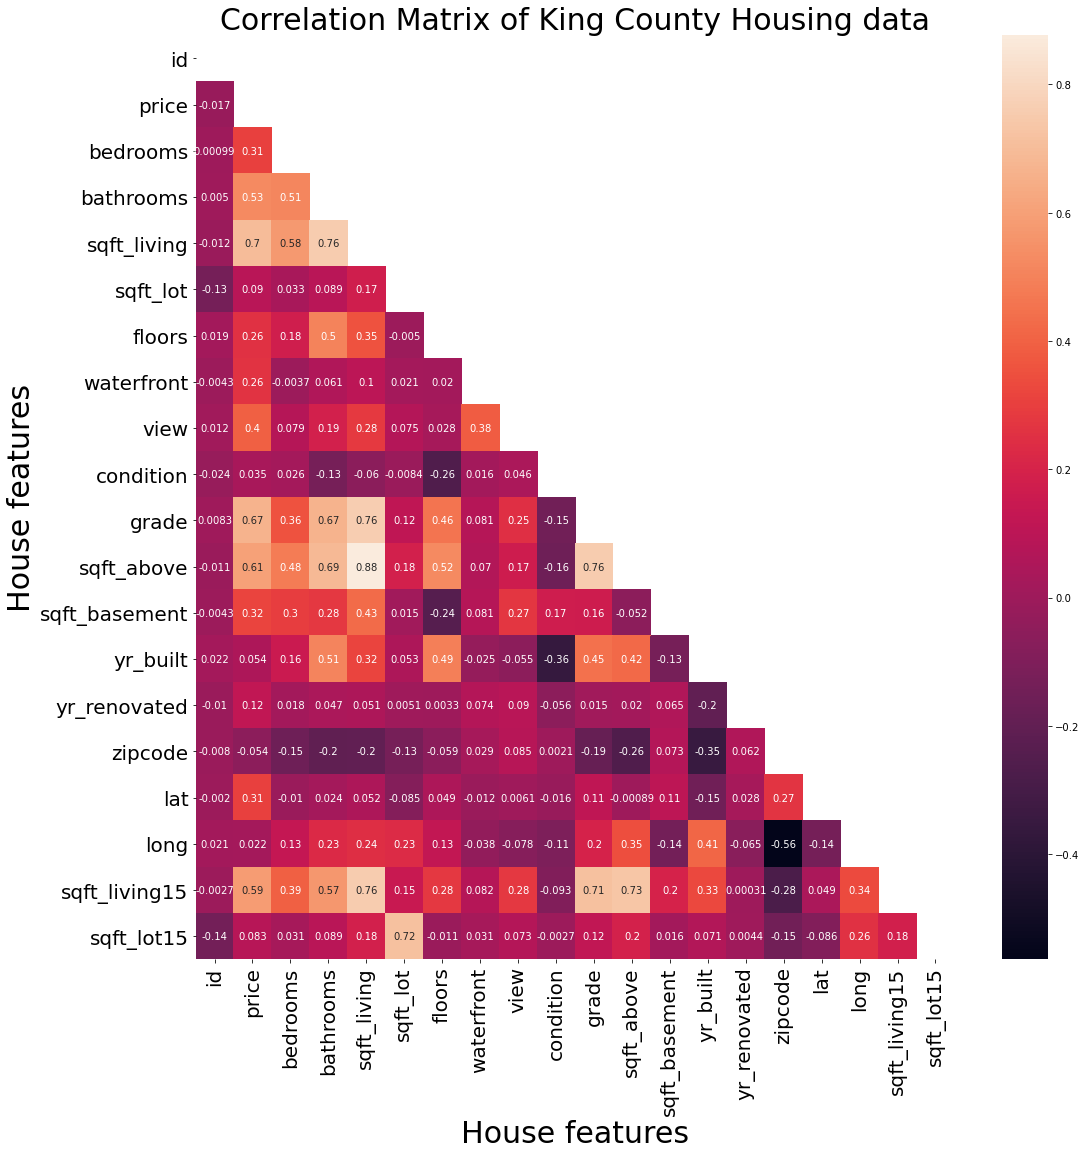

In [19]:
corrMatrix = df.corr()
matrix = np.triu(corrMatrix)

# Put corr matrix in seaborn heat map
fig, ax = plt.subplots(figsize=(17,17)) 
sns.heatmap(corrMatrix, annot=True, mask=matrix)
plt.title('Correlation Matrix of King County Housing data', size=30)
plt.xlabel('House features', size=30)
plt.ylabel('House features', size=30)
plt.xticks(size=20)
plt.yticks(size=20);

## Creating basic MPL and Seaborn visualizations based off of high/low corr

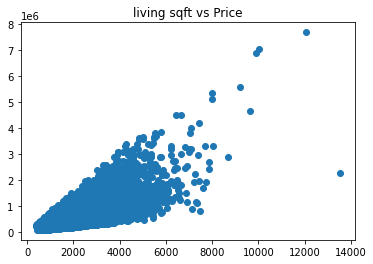

In [20]:
y = df['price']

X = df['sqft_living']

fig, ax = plt.subplots()
ax.scatter(X, y)
ax.set_title('living sqft vs Price');

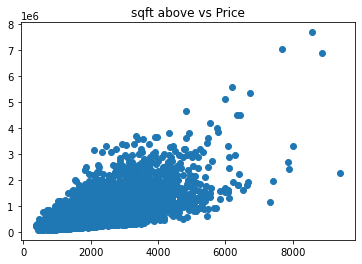

In [21]:
X1 = df['sqft_above']

fig, ax = plt.subplots()
ax.scatter(X1, y)
ax.set_title('sqft above vs Price');

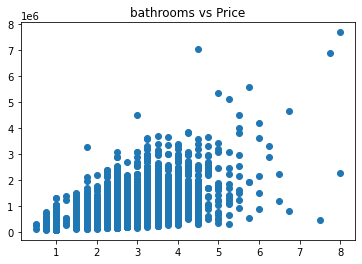

In [22]:
X2 = df['bathrooms']

fig, ax = plt.subplots()
ax.scatter(X2, y)
ax.set_title('bathrooms vs Price');

In [23]:
def determine_outlier_thresholds_iqr(dataframe, col_name, th1=0.25, th3=0.75):
    quartile1 = dataframe[col_name].quantile(th1)
    quartile3 = dataframe[col_name].quantile(th3)
    iqr = quartile3 - quartile1
    upper_limit = quartile3 + 1.5 * iqr
    lower_limit = quartile1 - 1.5 * iqr
    return upper_limit

In [24]:
#bedrooms = df.bedrooms.values
#upper_limit = determine_outlier_thresholds_iqr(df, 'bedrooms')
#irrelevant_col = df.apply(np.argwhere(determine_outlier_thresholds_iqr))
#bedrooms_to_drop = np.argwhere(bedrooms>upper_limit)

In [25]:
determine_outlier_thresholds_iqr(df, 'bedrooms')

5.5

In [26]:
lr = LinearRegression()

In [27]:
df.fillna(value=0, inplace=True)

X = df.drop(['price', 'date'], axis=1)
y = df[['price']]

lr.fit(X,y)
lr.score(X, y)

0.7002298349397336

In [28]:
#n = len(sample)
#mean = np.mean(sample)
#std = np.std(sample)

#SE = std / np.sqrt(n)
#z = stats.norm.ppf(.975)

#conf_low = mean - z*SE
#conf_high = mean + z*SE

#print(f'confidence interval, low: {conf_low}, high: {conf_high}')

## Normality check

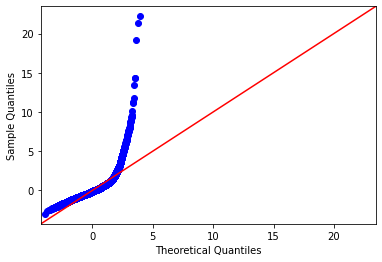

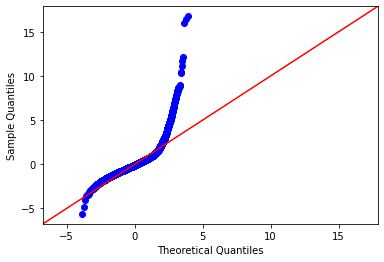

In [29]:
f2 = 'price ~ grade'
formula_b = 'price ~ sqft_living'
model_c = smf.ols(formula=f2, data=df).fit()
model_b2 = smf.ols(formula=formula_b, data=df).fit()
resid1 = model_c.resid
resid2 = model_b2.resid
fig = sm.graphics.qqplot(resid1, dist=stats.norm, line='45', fit=True)
fig = sm.graphics.qqplot(resid2, dist=stats.norm, line='45', fit=True)

In [30]:
sqft_liv_array = np.array(df['sqft_living'])
grade_array = np.array(df['grade'])

In [31]:
sqft_liv_log = np.log(sqft_liv_array)

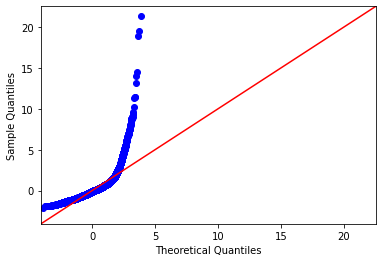

In [32]:
formula_b = 'price ~ sqft_liv_log'
model_b2 = smf.ols(formula=formula_b, data=df).fit()
resid2 = model_b2.resid
fig = sm.graphics.qqplot(resid2, dist=stats.norm, line='45', fit=True)

## Inferential models (ols)

In [33]:
formula = 'price ~ bedrooms + bathrooms + sqft_living + sqft_lot + floors + waterfront + view + condition + grade + sqft_above + sqft_basement + yr_built + yr_renovated'
model = ols(formula=formula, data=df).fit()
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.652
Model:                            OLS   Adj. R-squared:                  0.652
Method:                 Least Squares   F-statistic:                     3107.
Date:                Fri, 19 Nov 2021   Prob (F-statistic):               0.00
Time:                        08:17:48   Log-Likelihood:            -2.9504e+05
No. Observations:               21534   AIC:                         5.901e+05
Df Residuals:                   21520   BIC:                         5.902e+05
Df Model:                          13                                         
Covariance Type:            nonrobust                                         
=================================================================================
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
Intercept      6.569e+06   1.37e+05     48.082      0.000     6.3e+06    6.84e+06
bedrooms      -3.884e+04   2034.309    -19.094      0.000   -4.28e+04   -3.49e+04
bathrooms      4.554e+04   3499.986     13.012      0.000    3.87e+04    5.24e+04
sqft_living     112.5162     19.373      5.808      0.000      74.544     150.488
sqft_lot         -0.2609      0.037     -7.123      0.000      -0.333      -0.189
floors         2.457e+04   3736.893      6.576      0.000    1.72e+04    3.19e+04
waterfront      5.85e+05   1.95e+04     29.972      0.000    5.47e+05    6.23e+05
view           4.704e+04   2234.856     21.047      0.000    4.27e+04    5.14e+04
condition      1.953e+04   2491.635      7.840      0.000    1.47e+04    2.44e+04
grade          1.253e+05   2170.380     57.740      0.000    1.21e+05     1.3e+05
sqft_above       56.4561     19.317      2.923      0.003      18.593      94.319
sqft_basement    58.1595     19.205      3.028      0.002      20.517      95.802
yr_built      -3564.3563     70.159    -50.804      0.000   -3701.873   -3426.839
yr_renovated     13.1459      4.257      3.088      0.002       4.801      21.491
==============================================================================
Omnibus:                    15886.024   Durbin-Watson:                   1.978
Prob(Omnibus):                  0.000   Jarque-Bera (JB):          1070355.984
Skew:                           2.942   Prob(JB):                         0.00
Kurtosis:                      37.034   Cond. No.                     4.09e+06
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 4.09e+06. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [34]:
formula = 'price ~ bedrooms + bathrooms + sqft_living + sqft_lot + floors + waterfront + view + condition + grade + sqft_above + sqft_basement'
model = ols(formula=formula, data=df).fit()
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.605
Model:                            OLS   Adj. R-squared:                  0.605
Method:                 Least Squares   F-statistic:                     2999.
Date:                Fri, 19 Nov 2021   Prob (F-statistic):               0.00
Time:                        08:17:48   Log-Likelihood:            -2.9641e+05
No. Observations:               21534   AIC:                         5.928e+05
Df Residuals:                   21522   BIC:                         5.929e+05
Df Model:                          11                                         
Covariance Type:            nonrobust                                         
=================================================================================
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
Intercept     -3.348e+05   1.15e+04    -29.178      0.000   -3.57e+05   -3.12e+05
bedrooms       -3.41e+04   2165.068    -15.751      0.000   -3.83e+04   -2.99e+04
bathrooms     -1.512e+04   3495.309     -4.325      0.000    -2.2e+04   -8264.962
sqft_living     164.5602     20.620      7.981      0.000     124.144     204.977
sqft_lot         -0.3218      0.039     -8.246      0.000      -0.398      -0.245
floors        -2233.0830   3943.315     -0.566      0.571   -9962.273    5496.107
waterfront     5.921e+05   2.08e+04     28.492      0.000    5.51e+05    6.33e+05
view            6.27e+04   2361.459     26.551      0.000    5.81e+04    6.73e+04
condition      5.384e+04   2531.261     21.270      0.000    4.89e+04    5.88e+04
grade          1.039e+05   2273.387     45.686      0.000    9.94e+04    1.08e+05
sqft_above       22.8288     20.575      1.110      0.267     -17.501      63.158
sqft_basement    52.1551     20.466      2.548      0.011      12.041      92.270
==============================================================================
Omnibus:                    15503.073   Durbin-Watson:                   1.981
Prob(Omnibus):                  0.000   Jarque-Bera (JB):           901846.880
Skew:                           2.878   Prob(JB):                         0.00
Kurtosis:                      34.177   Cond. No.                     5.85e+05
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 5.85e+05. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [35]:
formula = 'price ~ sqft_living'

liv_mod = ols(formula=formula, data=df).fit()
liv_mod_sum = liv_mod.summary()

liv_mod_sum

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.492
Model:                            OLS   Adj. R-squared:                  0.492
Method:                 Least Squares   F-statistic:                 2.087e+04
Date:                Fri, 19 Nov 2021   Prob (F-statistic):               0.00
Time:                        08:17:49   Log-Likelihood:            -2.9912e+05
No. Observations:               21534   AIC:                         5.982e+05
Df Residuals:                   21532   BIC:                         5.983e+05
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
===============================================================================
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
Intercept   -4.215e+04   4404.521     -9.570      0.000   -5.08e+04   -3.35e+04
sqft_living   279.9321      1.938    144.473      0.000     276.134     283.730
==============================================================================
Omnibus:                    14582.265   Durbin-Watson:                   1.981
Prob(Omnibus):                  0.000   Jarque-Bera (JB):           516142.289
Skew:                           2.781   Prob(JB):                         0.00
Kurtosis:                      26.331   Cond. No.                     5.63e+03
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 5.63e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [36]:
formula1 = 'price ~ bedrooms'

bed_mod = ols(formula=formula1, data=df).fit()
bed_mod_sum = bed_mod.summary()

bed_mod_sum

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.095
Model:                            OLS   Adj. R-squared:                  0.095
Method:                 Least Squares   F-statistic:                     2258.
Date:                Fri, 19 Nov 2021   Prob (F-statistic):               0.00
Time:                        08:17:49   Log-Likelihood:            -3.0534e+05
No. Observations:               21534   AIC:                         6.107e+05
Df Residuals:                   21532   BIC:                         6.107e+05
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept   1.295e+05   8961.202     14.448      0.000    1.12e+05    1.47e+05
bedrooms    1.217e+05   2561.852     47.515      0.000    1.17e+05    1.27e+05
==============================================================================
Omnibus:                    18629.753   Durbin-Watson:                   1.961
Prob(Omnibus):                  0.000   Jarque-Bera (JB):          1154426.555
Skew:                           3.858   Prob(JB):                         0.00
Kurtosis:                      38.030   Cond. No.                         14.2
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [37]:
formula2 = 'price ~ bathrooms'

bath_mod = ols(formula=formula2, data=df).fit()
bath_mod_sum = bath_mod.summary()

bath_mod_sum

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.276
Model:                            OLS   Adj. R-squared:                  0.276
Method:                 Least Squares   F-statistic:                     8195.
Date:                Fri, 19 Nov 2021   Prob (F-statistic):               0.00
Time:                        08:17:49   Log-Likelihood:            -3.0294e+05
No. Observations:               21534   AIC:                         6.059e+05
Df Residuals:                   21532   BIC:                         6.059e+05
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept   1.099e+04   6217.943      1.768      0.077   -1195.842    2.32e+04
bathrooms   2.501e+05   2762.313     90.527      0.000    2.45e+05    2.55e+05
==============================================================================
Omnibus:                    17084.255   Durbin-Watson:                   1.959
Prob(Omnibus):                  0.000   Jarque-Bera (JB):           857836.558
Skew:                           3.421   Prob(JB):                         0.00
Kurtosis:                      33.154   Cond. No.                         7.76
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [38]:
df.columns

Index(['id', 'date', 'price', 'bedrooms', 'bathrooms', 'sqft_living',
       'sqft_lot', 'floors', 'waterfront', 'view', 'condition', 'grade',
       'sqft_above', 'sqft_basement', 'yr_built', 'yr_renovated', 'zipcode',
       'lat', 'long', 'sqft_living15', 'sqft_lot15'],
      dtype='object')

In [39]:
df.head()

,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,...,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
0,7129300520,10/13/2014,221900.0,3,1.00,1180,5650,1.0,0.0,0.0,...,4,1180,0.0,1955,0.0,98178,47.5112,-122.257,1340,5650
1,6414100192,12/9/2014,538000.0,3,2.25,2570,7242,2.0,0.0,0.0,...,4,2170,400.0,1951,1991.0,98125,47.7210,-122.319,1690,7639
2,5631500400,2/25/2015,180000.0,2,1.00,770,10000,1.0,0.0,0.0,...,3,770,0.0,1933,0.0,98028,47.7379,-122.233,2720,8062
3,2487200875,12/9/2014,604000.0,4,3.00,1960,5000,1.0,0.0,0.0,...,4,1050,910.0,1965,0.0,98136,47.5208,-122.393,1360,5000
4,1954400510,2/18/2015,510000.0,3,2.00,1680,8080,1.0,0.0,0.0,...,5,1680,0.0,1987,0.0,98074,47.6168,-122.045,1800,7503


In [40]:
formula3 = 'price ~ bedrooms+bathrooms+sqft_living+sqft_lot+floors+waterfront+view+condition+grade+sqft_above+sqft_basement'

room_mod = ols(formula=formula3, data=df).fit()
room_mod_sum = room_mod.summary()

room_mod_sum

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.605
Model:                            OLS   Adj. R-squared:                  0.605
Method:                 Least Squares   F-statistic:                     2999.
Date:                Fri, 19 Nov 2021   Prob (F-statistic):               0.00
Time:                        08:17:49   Log-Likelihood:            -2.9641e+05
No. Observations:               21534   AIC:                         5.928e+05
Df Residuals:                   21522   BIC:                         5.929e+05
Df Model:                          11                                         
Covariance Type:            nonrobust                                         
=================================================================================
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
Intercept     -3.348e+05   1.15e+04    -29.178      0.000   -3.57e+05   -3.12e+05
bedrooms       -3.41e+04   2165.068    -15.751      0.000   -3.83e+04   -2.99e+04
bathrooms     -1.512e+04   3495.309     -4.325      0.000    -2.2e+04   -8264.962
sqft_living     164.5602     20.620      7.981      0.000     124.144     204.977
sqft_lot         -0.3218      0.039     -8.246      0.000      -0.398      -0.245
floors        -2233.0830   3943.315     -0.566      0.571   -9962.273    5496.107
waterfront     5.921e+05   2.08e+04     28.492      0.000    5.51e+05    6.33e+05
view            6.27e+04   2361.459     26.551      0.000    5.81e+04    6.73e+04
condition      5.384e+04   2531.261     21.270      0.000    4.89e+04    5.88e+04
grade          1.039e+05   2273.387     45.686      0.000    9.94e+04    1.08e+05
sqft_above       22.8288     20.575      1.110      0.267     -17.501      63.158
sqft_basement    52.1551     20.466      2.548      0.011      12.041      92.270
==============================================================================
Omnibus:                    15503.073   Durbin-Watson:                   1.981
Prob(Omnibus):                  0.000   Jarque-Bera (JB):           901846.880
Skew:                           2.878   Prob(JB):                         0.00
Kurtosis:                      34.177   Cond. No.                     5.85e+05
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 5.85e+05. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [41]:
df.columns

Index(['id', 'date', 'price', 'bedrooms', 'bathrooms', 'sqft_living',
       'sqft_lot', 'floors', 'waterfront', 'view', 'condition', 'grade',
       'sqft_above', 'sqft_basement', 'yr_built', 'yr_renovated', 'zipcode',
       'lat', 'long', 'sqft_living15', 'sqft_lot15'],
      dtype='object')

In [42]:
X = df[['sqft_living','bedrooms','bathrooms','sqft_lot','floors','waterfront', 'view', 'condition', 'grade', 'sqft_above', 'sqft_basement']]
y = df['price']
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size = 0.7, test_size = 0.3, random_state = 100)

In [43]:
X_train_sm = sm.add_constant(X_train)

In [44]:
lrr = sm.OLS(y_train, X_train_sm).fit()
lrr.params

const           -338234.480118
sqft_living         151.467558
bedrooms         -34636.957461
bathrooms        -13426.285156
sqft_lot             -0.339399
floors            -3151.793390
waterfront       556239.021454
view              64000.974878
condition         55064.096706
grade            102674.171125
sqft_above           39.755366
sqft_basement        60.612177
dtype: float64

In [45]:
lrr.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.602
Model:                            OLS   Adj. R-squared:                  0.602
Method:                 Least Squares   F-statistic:                     2070.
Date:                Fri, 19 Nov 2021   Prob (F-statistic):               0.00
Time:                        08:17:49   Log-Likelihood:            -2.0753e+05
No. Observations:               15073   AIC:                         4.151e+05
Df Residuals:                   15061   BIC:                         4.152e+05
Df Model:                          11                                         
Covariance Type:            nonrobust                                         
=================================================================================
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
const         -3.382e+05   1.37e+04    -24.629      0.000   -3.65e+05   -3.11e+05
sqft_living     151.4676     26.174      5.787      0.000     100.164     202.771
bedrooms      -3.464e+04   2551.880    -13.573      0.000   -3.96e+04   -2.96e+04
bathrooms     -1.343e+04   4185.319     -3.208      0.001   -2.16e+04   -5222.550
sqft_lot         -0.3394      0.045     -7.534      0.000      -0.428      -0.251
floors        -3151.7934   4724.597     -0.667      0.505   -1.24e+04    6108.992
waterfront     5.562e+05   2.52e+04     22.115      0.000    5.07e+05    6.06e+05
view             6.4e+04   2851.793     22.442      0.000    5.84e+04    6.96e+04
condition      5.506e+04   3026.891     18.192      0.000    4.91e+04     6.1e+04
grade          1.027e+05   2716.461     37.797      0.000    9.73e+04    1.08e+05
sqft_above       39.7554     26.118      1.522      0.128     -11.439      90.950
sqft_basement    60.6122     25.996      2.332      0.020       9.656     111.568
==============================================================================
Omnibus:                    11836.556   Durbin-Watson:                   2.001
Prob(Omnibus):                  0.000   Jarque-Bera (JB):           941233.313
Skew:                           3.193   Prob(JB):                         0.00
Kurtosis:                      41.182   Cond. No.                     6.10e+05
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 6.1e+05. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [46]:
y_train_pred = lrr.predict(X_train_sm)

res = (y_train, y_train_pred)

<Figure size 432x288 with 0 Axes>

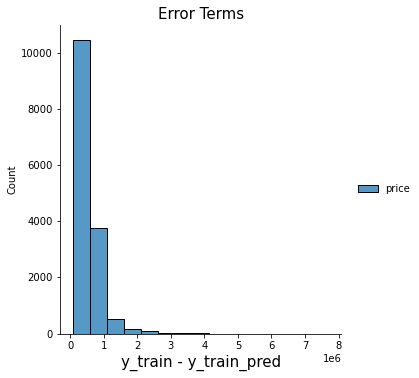

In [47]:
fig = plt.figure()
sns.displot(res, bins = 15)
plt.title('Error Terms', fontsize = 15)
plt.xlabel('y_train - y_train_pred', fontsize = 15)
plt.show()

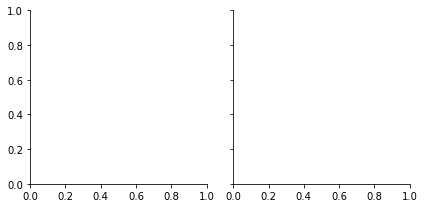

In [48]:
g = sns.FacetGrid(df, col="waterfront")

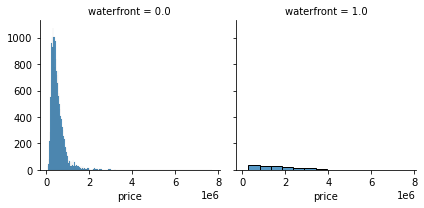

In [49]:
g.map(sns.histplot, "price")

In [50]:
models_num = np.array([.602, .605, .276, .095, .492, .651])
models = ['Model 1', 'Model 2', 'Model 3', 'Model 4', 'Model 5', 'Final Model']

In [51]:
models_num.sort()
models_num

array([0.095, 0.276, 0.492, 0.602, 0.605, 0.651])

<BarContainer object of 6 artists>

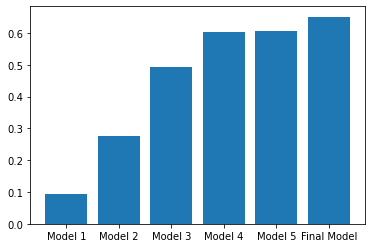

In [52]:
plt.bar(models, height=models_num )

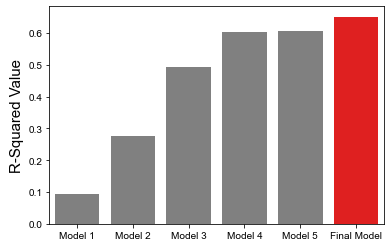

In [53]:
clrs = ['grey' if (x < max(models_num)) else 'red' for x in models_num ]
sns.barplot(x=models, y=models_num, palette=clrs)
plt.ylabel('R-Squared Value', size=15)
plt.savefig('../images/ModelProgression.png')
sns.set_style('dark')

In [ ]:
formula = 'price ~ bedrooms + bathrooms + sqft_living + sqft_lot + floors + waterfront + view + condition + grade + sqft_above + sqft_basement + yr_built + yr_renovated'
#Included everything about the house, not the date or the neighborhood.
model = ols(formula=formula, data=df).fit()
model.summary()

Because it has most of the features in the model, the R-Squared value is most likely going to be highest, however it is still worth a look to see how price correlates/is affected by other factors in the data

It also shows us that we are violating atleast two of the assumptions of linear regression (Normality, Multicollinearity)

In [ ]:
formula = 'price ~ bedrooms + bathrooms + sqft_living + sqft_lot + floors + waterfront + view + condition + grade + sqft_above + sqft_basement'
#dropped a few categories, no relevant change in the data, still violates assumptions.
model = ols(formula=formula, data=df).fit()
model.summary()

In [ ]:
formula4 = 'price ~ sqft_living'
#testing individuals to see how they correlate, and which assumptions they violate individually
#sqft_living, while a key factor and statistically significant to price, is not a normal distribution, 
#and there is clear collinearity issues.
liv_mod = ols(formula=formula4, data=df).fit()
liv_mod_sum = liv_mod.summary()

liv_mod_sum

In [ ]:
formula1 = 'price ~ bedrooms'
#Bedrooms is not a normal distribution, BUT it does not have collinearity issues on the surface level, due to the 
#coef vs std err AND Cond. No. being between 10-30. Statistically significant according to the model, but only accounts for
#(almost) 10% of the data
bed_mod = ols(formula=formula1, data=df).fit()
bed_mod_sum = bed_mod.summary()

bed_mod_sum

In [ ]:
formula3 = 'price ~ bedrooms+bathrooms+sqft_living+sqft_lot+floors+waterfront+view+condition+grade+sqft_above+sqft_basement'
#It seems if we are just going to accept the fact that our LINEAR model is going to have issues with assumptions.
#It would be best to include more data so we atleast have a higher R-Squared and can account for more variance within our model
room_mod = ols(formula=formula3, data=df).fit()
room_mod_sum = room_mod.summary()

room_mod_sum

In [ ]:
formula2 = 'price ~ bathrooms'
#Like bedrooms, not a normal distribution, but it doesnt seem to have collinearity AND its statistically significant while holding
#a solid R-Squared score.
bath_mod = ols(formula=formula2, data=df).fit()
bath_mod_sum = bath_mod.summary()

bath_mod_sum

In [ ]:
X = df[['sqft_living','bedrooms','bathrooms','sqft_lot','floors','waterfront', 'view', 'condition', 'grade', 'sqft_above', 'sqft_basement']]
y = df['price']
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size = 0.7, test_size = 0.3, random_state = 100)

In [54]:
X_train_sm = sm.add_constant(X_train)

lrr = sm.OLS(y_train, X_train_sm).fit()
lrr.params